**Name: `Suman Pal`** <br>
**Roll: `19BM6JP22`** <br>
**Course: `Regression and Time Series Modelling (RTSM)`** <br>
**Assignment-2**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('MLR_data.csv')
cols = ['V1','V2','V3','V4','V5','V6','V7','V8']
data = data[cols]
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8
0,70.157664,1,10,6,0.672347,2.239792,0.637664,-3.841915
1,75.172848,1,10,4,0.251939,1.810250,1.050037,8.391126
2,73.492166,1,8,6,0.281328,2.247168,0.947496,3.917238
3,71.656961,1,10,7,0.328874,2.478223,0.361662,-5.056545
4,65.998205,1,8,4,0.364254,1.679748,0.575510,10.065619


In [3]:
for i in cols:
    print(i, data[i].nunique())

V1 1000
V2 1
V3 14
V4 16
V5 1000
V6 1000
V7 1000
V8 1000


**Target Variable:** V1 <br>
  **Continuous variables:** V5, V6, V7, V8 <br>
  **Categorical variables:** V3, V4 <br>
  **Intercept coefficient(Bo) accounted in:** V2
  
  Therefore, the given data has 6 explanatory variables out of which 4 are continuous and rest 2 are categorical. 
  The job in hand is to come up with a regression model that explain the system variance in the best possible way.

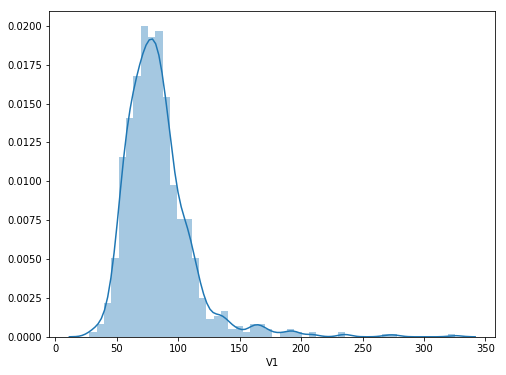

In [4]:
plt.figure(figsize=(8,6))
sns.distplot(data['V1'])

The data for target variable seem to be a skewed normal distribution. We should test for its normality.

**Test of normality for the output variable**

In [5]:
# null hypothesis: Y comes from a normal distribution
from scipy import stats
k2, p = stats.normaltest(data['V1'])
if p < 1e-3:  
    print("p = {:g}".format(p))
    print("The null hypothesis is rejected")
else:
    print("p = {:g}".format(p))
    print("We fail to reject the null hypothesis")

p = 2.74253e-128
The null hypothesis is rejected


Given that the distribution is skewed, we can try log transformation and check for its normality

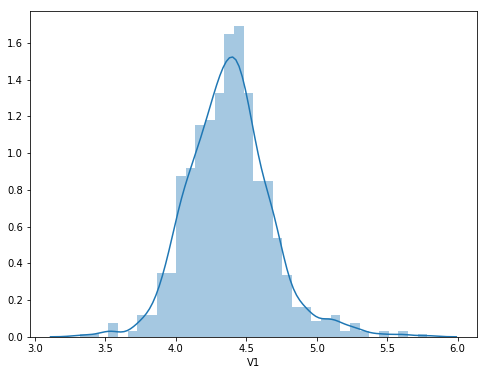

In [6]:
plt.figure(figsize=(8,6))
sns.distplot(np.log(data['V1']))

In [7]:
# Log-transforming the output variable
k2, p = stats.normaltest(np.log(data['V1']))
if p < 1e-3:  
    print("p = {:g}".format(p))
    print("The null hypothesis is rejected")
else:
    print("p = {:g}".format(p))
    print("We fail to reject the null hypothesis")

p = 6.4383e-18
The null hypothesis is rejected


Though the null hypothesis is rejected, still the p value is significantly improved after transformation

### Sampling from data

#### 1. Random Sampling without replacement

In [8]:
from sklearn.model_selection import train_test_split
col_ex = cols.copy()
col_ex.remove('V1')
x_train, x_test, y_train, y_test = train_test_split(data[col_ex], data['V1'], random_state = 0, test_size = 0.15)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(850, 7) (150, 7) (850,) (150,)


Text(0.5, 1.05, 'Correlation Matrix')

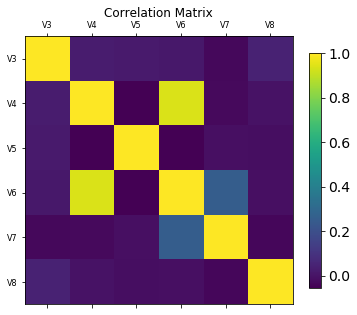

In [9]:
import matplotlib.pyplot as plt

col_coeff = col_ex.copy()
col_coeff.remove('V2')
f = plt.figure(figsize=(6, 6))
plt.matshow(data[col_coeff].corr(), fignum=f.number)
plt.xticks(range(data[col_coeff].shape[1]), data[col_coeff].columns, fontsize=8, rotation=0)
plt.yticks(range(data[col_coeff].shape[1]), data[col_coeff].columns, fontsize=8)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=12)

**Points to note:**
1. Variables V4 and V6 are highly correlated
2. Variables V6 and V7 are mildly correlated
3. Rest of the variables do not show high degree of correlation <br>

**PCA can be performed to improve independency of explanatory variables**

In [10]:
from numpy import linalg as la
rank = la.matrix_rank(la.inv(np.transpose(x_train)@x_train))
det = la.det(np.transpose(x_train)@x_train)
print(f'The rank of matrix xtx-1 is: {rank}')
print(f'The determinant of matrix xtx is: {det}')

The rank of matrix xtx-1 is: 7
The determinant of matrix xtx is: 2.0326705544585527e+19


The matrix is full rank, the determinant of the matrix is also very high. Hence, there is no case of multicollinearity. So there is no need of PCA to be performed.

In [11]:
from sklearn import linear_model

regr = linear_model.LinearRegression() 
# Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(x_train[col_coeff], y_train)
predicted = regr.predict(x_test[col_coeff])
print(f' R2 for train model is: {regr.score(x_train[col_coeff], y_train)}')
print(f' coeff for model is: {regr.coef_}')
print(f' intercept for model is: {regr.intercept_}')

 R2 for train model is: 0.3785486989870638
 coeff for model is: [ 3.16953857  6.19261633  5.65270114 -2.12191626 13.38266997  1.00807445]
 intercept for model is: 5.593563401923305


In [12]:
train_preds = regr.predict(x_train[col_coeff])
error = y_train-train_preds

sigma_sq_hat = (np.transpose(error)@error)/(x_train.shape[0]-1-x_train.shape[1])
print(sigma_sq_hat)

498.15343338297845


In [13]:
temp_matrix = np.array(x_train)@(la.inv(np.transpose(np.array(x_train))@np.array(x_train)))
proj_matrix = np.array(temp_matrix)@np.transpose(np.array(x_train))

proj_preds = proj_matrix@np.array(y_train)
print(f'Projection_matrix: {proj_matrix}\n\nThe difference between analytical and theoretical predictions: {np.mean(proj_preds-train_preds)}')

Projection_matrix: [[ 5.51433420e-03 -1.19997029e-05  2.21584442e-03 ... -8.57912669e-04
   6.35303004e-03  2.16027493e-03]
 [-1.19997029e-05  5.51775190e-03 -3.13495645e-04 ... -7.05463598e-04
  -1.18389021e-03  2.18137777e-03]
 [ 2.21584442e-03 -3.13495645e-04  7.29091431e-03 ...  7.51430736e-04
   3.78372508e-03 -1.47370893e-04]
 ...
 [-8.57912669e-04 -7.05463598e-04  7.51430736e-04 ...  5.98885871e-03
  -1.67931585e-04  6.20710424e-04]
 [ 6.35303004e-03 -1.18389021e-03  3.78372508e-03 ... -1.67931585e-04
   9.79560316e-03  1.04203159e-03]
 [ 2.16027493e-03  2.18137777e-03 -1.47370893e-04 ...  6.20710424e-04
   1.04203159e-03  4.32214276e-03]]

The difference between analytical and theoretical predictions: -3.538753603874391e-12


The predictions from the regression model and the projection matrix do not differ significantly and hence our model is correct.

**Error Analysis**

In [14]:
eye = np.eye(x_train.shape[0])
var_matrix = sigma_sq_hat*(eye-proj_matrix)
cols = [str(num) for num in np.arange(1,851)]
var_df = pd.DataFrame(var_matrix.astype('float'), columns = cols)

In [15]:
var_df.head()

,1,2,3,4,5,6,7,8,9,10,...,841,842,843,844,845,846,847,848,849,850
0,495.406449,0.005978,-1.103831,-1.072855,-0.031299,-0.645460,-0.508689,0.518504,0.794147,-2.530477,...,0.030798,-0.864051,-1.381424,-1.159196,-1.959932,0.517573,-2.348913,0.427372,-3.164784,-1.076148
1,0.005978,495.404746,0.156169,1.191245,-0.175217,0.013857,0.770090,-1.167604,-0.875462,-0.488650,...,-2.269533,0.089139,0.810675,-1.086817,0.107391,0.158138,-1.949645,0.351429,0.589759,-1.086661
2,-1.103831,0.156169,494.521439,-0.233225,-0.267717,0.224451,-1.164228,-2.149420,-2.130888,1.060833,...,-0.589061,-2.196023,-2.725934,-1.174290,-1.176543,-0.739653,2.417189,-0.374328,-1.884876,0.073413
3,-1.072855,1.191245,-0.233225,493.205203,-0.156358,1.141258,-3.218133,1.389312,-0.808340,-0.289349,...,-1.008129,-0.686682,-1.900913,2.612006,-0.164299,-1.479219,-1.491106,-2.618305,-0.963214,-1.853432
4,-0.031299,-0.175217,-0.267717,-0.156358,494.455217,-3.125379,-0.490488,-2.458359,0.522764,-0.789201,...,1.612434,-0.799234,0.990513,-0.054127,-0.160963,-2.300288,0.982092,-2.075369,-1.020373,0.946005


Text(0.5, 1.05, 'Error Covariance Matrix')

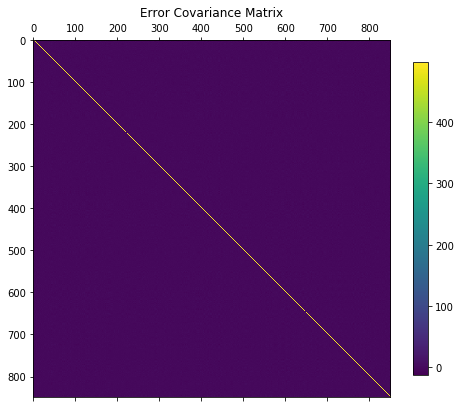

In [16]:
f = plt.figure(figsize=(8, 8))
plt.matshow(var_df, fignum=f.number)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=10)
plt.title('Error Covariance Matrix', fontsize=12)

Only the diagonal elements are close to sigma_sq_hat and rest others are close to 0. This means that the error-error covariance is close to 0 **(errors are independtly distributed)** for each distinct pair.

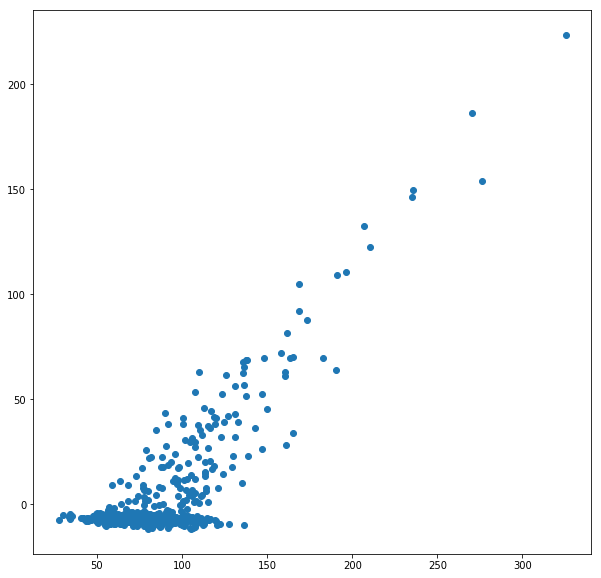

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, error)

It is evident from the plot that, a small chunk of the data has abnormally high errors(i.e. outliers) and high leverage as well. These are influential points and are influencing the estimate of the model parameters. Thus we wish to remove these points and re-estimate our model paramaters. 

**Removing Outliers**

We will remove 5% of the data points based on standardised residuals. The step by step approach is expressed below.

In [18]:
x = data[col_ex]
y = data['V1']

In [19]:
regr.fit(x,y)
train_preds = regr.predict(x)
error = y-train_preds

sigma_sq_hat = (np.transpose(error)@error)/(x.shape[0]-1-x.shape[1])
print(sigma_sq_hat)

521.1012575945155


In [20]:
temp_matrix = np.array(x)@(la.inv(np.transpose(np.array(x))@np.array(x)))
proj_matrix = np.array(temp_matrix)@np.transpose(np.array(x))

In [21]:
def standardized_residual(H,sigma,e):
    h_ii = np.diagonal(H)
    studentized_residual = e/np.sqrt(sigma*(1-h_ii))
    return studentized_residual

In [22]:
data['standardized_residual'] = standardized_residual(proj_matrix,sigma_sq_hat,error)

In [23]:
new_df = data.sort_values(by='standardized_residual',ascending=True)
new_df.drop('standardized_residual',axis=1,inplace=True)
new_data = new_df[:925]
print(new_data.columns, new_data.shape)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'], dtype='object') (925, 8)


#### 2. Sampling after removing outliers

In [24]:
x_train, x_test, y_train, y_test = train_test_split(new_data[col_ex], new_data['V1'], random_state = 0, test_size = 75)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(850, 7) (75, 7) (850,) (75,)


In [25]:
regr = linear_model.LinearRegression() 

regr.fit(x_train[col_coeff], y_train)
predicted = regr.predict(x_test[col_coeff])
print(f' R2 for model is: {regr.score(x_train[col_coeff], y_train)}')
print(f' coeff for model is: {regr.coef_}')
print(f' intercept for model is: {regr.intercept_}')

 R2 for model is: 0.8876528894722242
 coeff for model is: [ 3.45884599  5.5985046  -0.14229334 -1.06706179 10.08115183  1.05568679]
 intercept for model is: 3.4105799195640003


The explained variance of the data by the model is now increased to **0.78** from previous **0.38**. This means that removing outliers did help. Let's see its error analysis again.

**Error Analysis**

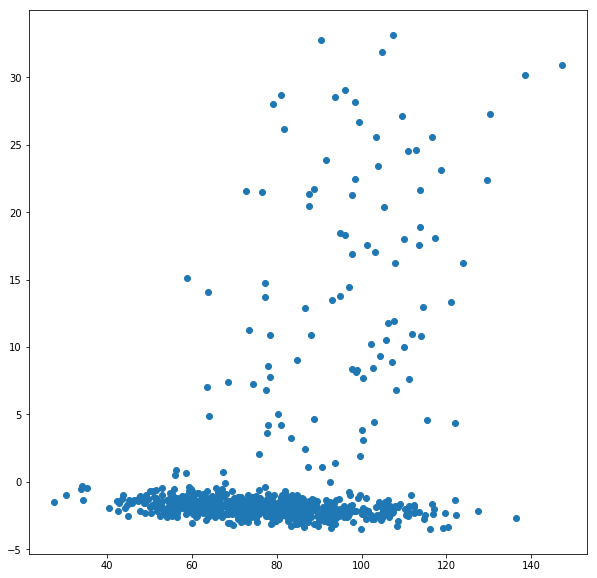

In [26]:
train_preds = regr.predict(x_train[col_coeff])
error = y_train-train_preds

plt.figure(figsize=(10,10))
plt.scatter(y_train, error)

We find a reduction in the error range from previous ~300 to current ~50. But still, we have influential points and we wish to remove them from our training data using Cook's distance.

#### Detecting Influential points by using Cook's distance

In [27]:
!pip install yellowbrick

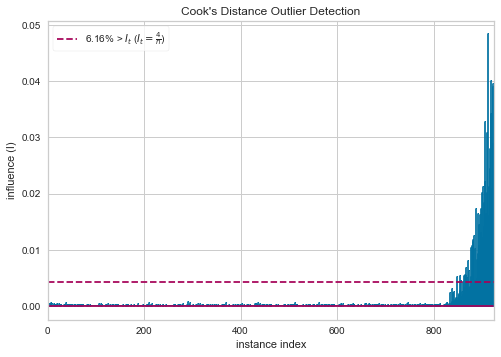

In [28]:
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance()
visualizer.fit(new_data[col_ex], new_data['V1'])
visualizer.show()

**Observations:**
The highly influential points are in between instance index of 600 to 800. These data points are constituting the influential points(outliers/leverage points).

In [29]:
new_data['Cook_dist'] = visualizer.distance_
new_data = new_data.sort_values(by='Cook_dist',ascending=True)
new_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Cook_dist
645,92.651825,1,11,7,0.337520,1.944606,0.272661,10.814352,6.022941e-07
689,67.827643,1,8,6,0.587743,2.272736,0.397583,1.662565,2.311965e-06
765,77.291701,1,12,3,0.460792,1.664131,1.130488,6.054996,2.531113e-06
617,59.788201,1,9,4,0.546149,1.830717,0.941961,-3.882676,5.542256e-06
600,58.589202,1,8,6,0.338248,2.461801,0.376304,-7.436501,5.608586e-06


#### 3. Sampling after removing outliers and high leverage points

In [30]:
x_train, y_train = new_data[col_ex][:850], new_data['V1'][:850]
print(x_train.shape, y_train.shape)

(850, 7) (850,)


In [31]:
regr = linear_model.LinearRegression() 

regr.fit(x_train[col_coeff], y_train)
print(f' R2 for model is: {regr.score(x_train[col_coeff], y_train)}')
print(f' coeff for model is: {regr.coef_}')
print(f' intercept for model is: {regr.intercept_}')

 R2 for model is: 0.993045173428823
 coeff for model is: [3.4270002  4.9500842  0.60869016 1.09480204 8.19311129 1.01698431]
 intercept for model is: 2.1897876988784475


The R2 for this regression model has reached **0.99** from previous **0.71**. This means that removing outliers as well as high leverage points both has helped in defining a regression model that can explain almost all of the variance in the data.

**Error Analysis**

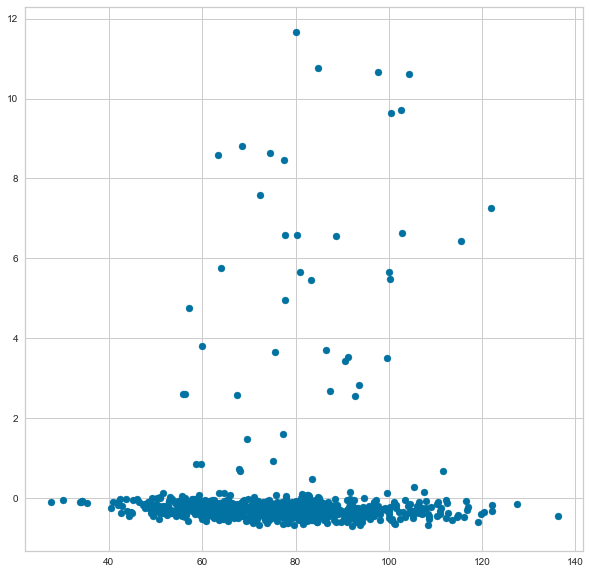

In [32]:
train_preds = regr.predict(x_train[col_coeff])
error = y_train-train_preds

plt.figure(figsize=(10,10))
plt.scatter(y_train, error)

In the above plot, the error margin has drastically decreased for most of the data points. Also, there are only a countful data points whose variance can not be explained by the model. Hence, this regression model can be treated as the best fit for the given data and can be further used to prediction purposes on an unseen data.

In [33]:
len(error[error>0.30])

45

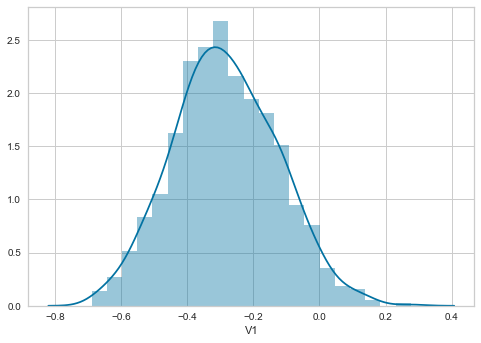

In [34]:
sns.distplot(error[error<0.3])

There are 50 data points which are still having high errors. Lets check the normality of the rest of the error data

In [35]:
k2, p = stats.normaltest(error[error<0.3])
if p < 1e-3:  
    print("p = {:g}".format(p))
    print("The null hypothesis is rejected")
else:
    print("p = {:g}".format(p))
    print("We fail to reject the null hypothesis")

p = 0.172218
We fail to reject the null hypothesis


Hence, the errors follow a normal distribution which is line with the assumption of our model used.

**Final R2 statistics for the process shown above:**
1. Model with influential points: 0.38
2. Model with outlier removal: 0.71
3. Moel without influential points: 0.99 